# Goal
We want $$0 = \dot{\hat{\rho}} = \mathcal{L}\hat{\rho} = -i\left[\hat H, \hat \rho\right]+\sum_j \frac{\gamma_j}{2}\left[2\hat L_j\hat\rho\hat L_j^\dagger - \left\{\hat L_j^\dagger\hat L_j, \hat\rho\right\}\right]$$

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

Pauli Matrices

In [2]:
sigma_x = np.array([[0, 1], [1, 0]], dtype = 'complex128')
sigma_y = np.array([[0, -1j], [1j, 0]], dtype = 'complex128')
sigma_z = np.array([[1, 0], [0, -1]], dtype = 'complex128')
identity = np.array([[1, 0], [0, 1]], dtype = 'complex128')

Some parameters

In [3]:
num_latt = 4
coup_stren = 2


$$ H = \frac{V}{4}\sum_{\langle j, l\rangle}\hat\sigma_j^z\sigma_l^z+\frac{g}{2}\sum_j\hat\sigma_j^x$$
where $\hat\sigma_j^\alpha$ means the Pauli matrix acting on the $j$-th site.
$$ \hat L_j^{(z)} = \hat\sigma_j^- = \frac{1}{2}\left(\hat\sigma_j^x-i\hat\sigma_j^y\right)$$

In [4]:
# make tensor product of two matrices (copied over from povm code, 
# but I didn't reverse the order because later I shall use this function
# in a different order.)
def tensorproduct(matrix1, matrix2):
    dim = matrix1.shape[0] * matrix2.shape[0]
    # didn't reverse the order here
    return np.tensordot(matrix1, matrix2, axes = 0).swapaxes(1, 2).reshape(dim, dim)

In [5]:
# generate hamiltonion
def gen_H(num, V, g):
    hamiltonion = np.zeros((2**num, 2**num), dtype = 'complex128')
    for i in range(num):
        term1 = np.ones((1, 1), dtype = 'complex128')
        term2 = np.ones((1, 1), dtype = 'complex128')
        for j in range(num): 
            if j == i or j == i + 1 or (i == num - 1 and j == 0): # wallpaper(cyclic) bondary condition
                term1 = tensorproduct(term1, sigma_z) # order here not the same as in POVM
                #print(i, j)
                #print(term1)
            else:
                term1 = tensorproduct(term1, identity) # order here not the same as in POVM
            if j == i:
                term2 = tensorproduct(term2, sigma_x) # order here not the same as in POVM
            else:
                term2 = tensorproduct(term2, identity) # order here not the same as in POVM
        term1 = term1 * V / 4
        #print(term1)
        term2 = term2 * g / 2
        hamiltonion += term1 + term2
    return hamiltonion
                

In [6]:
# generate L_j
def gen_L_j(num, i):
    term = np.ones((1, 1), dtype = 'complex128')
    for j in range(num):
        if j == i:
            term = tensorproduct(term, (sigma_x - 1j * sigma_y) / 2)
        else:
            term = tensorproduct(term, identity)
    return term
            

In [7]:
# remember to test the functions above

In [8]:
def curly_L(rho, V, g): # input should be a matrix of 2**num_latt * 2**num_latt and I ignored the gamma and assume it's the unit
    h = gen_H(num_latt, V, g)
    rho = rho.reshape((2**num_latt, 2**num_latt))
    #print(rho.shape, h.shape)
    #print(rho.dtype, h.dtype)
    term1 = -1j * (h @ rho - rho @ h)
    term2 = np.zeros((2**num_latt, 2**num_latt), dtype = 'complex128')
    for i in range(num_latt):
        Li = np.matrix(gen_L_j(num_latt, i))
        term2 += (2 * Li@rho@Li.H - Li.H@Li@ rho - rho@Li.H@Li) / 2
    return (term1 + term2)
    

In [9]:
def gen_rho(parameters):
    matrix = np.array(np.append(parameters, 0))
    length = int(round(np.sqrt(matrix.size)))
    matrix = matrix.reshape(length, length)
    # extract upper trangle (excluding diagonal)
    upper = np.triu(matrix, k=1)
    # extract lower trangle (excluding diagonal)
    lower = np.tril(matrix, k=-1)
    # extract diagonal
    diagnal = np.diag(matrix)
    # sum of diagonal (trace) should be 1
    diagnal.flags.writeable = True # otherwise is read only, not sure why
    diagnal[-1] = 1 - np.sum(diagnal[:-1])
    # take the upper triangle and diagonal as the real part of the matrix
    real = upper + upper.T + np.diag(diagnal)
    # take the lower tirangle as the imaginary part of the matrix
    imaginary = 1j * lower - 1j * lower.T
    return real + imaginary
    

In [10]:
gen_rho(np.random.random(4**2 -1))

array([[ 0.64821754+0.j        ,  0.11325262-0.40235462j,
         0.61708079-0.47948023j,  0.11356121-0.81128431j],
       [ 0.11325262+0.40235462j,  0.31921399+0.j        ,
         0.20602469-0.75222091j,  0.17579587-0.14325157j],
       [ 0.61708079+0.47948023j,  0.20602469+0.75222091j,
         0.70889925+0.j        ,  0.28039585-0.42958215j],
       [ 0.11356121+0.81128431j,  0.17579587+0.14325157j,
         0.28039585+0.42958215j, -0.67633078+0.j        ]])

In [11]:
def gen_rho_dot(parameters, V, g):
    rho = gen_rho(parameters)
    rho_dot = curly_L(rho, V, g)
    return rho_dot

In [12]:
def loss(parameters, V, g):
    rho_dot = gen_rho_dot(parameters, V, g)
    #print(0)
    return np.linalg.norm(rho_dot)

In [13]:
def train(parameters,V,g, max_iter=10, step_rate=0.1):
        
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], loss(x, V, g)))
        
    parameters = np.array(parameters)
    from scipy.optimize import minimize
    res = minimize(loss, x0=parameters, args = (V, g), \
                       method='L-BFGS-B', jac = '2-point', tol=1e-10, \
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0}, \
                       callback=callback)
    return res.fun, res.x

In [14]:
g_list = np.linspace(1, 4, 7)
optimized_parameters_list = []
loss_list = []
for g in g_list:
    initial_parameters = np.random.random(4**num_latt - 1)
    #loss, optimized_parameters = train(initial_parameters, 2, g)
    res = optimize.minimize(loss, initial_parameters, args = (coup_stren, g))
    optimized_parameters = res.x
    loss_value = res.fun
    optimized_parameters_list.append(optimized_parameters)
    loss_list.append(loss_value)
    print(g)
rho_list = list(map(gen_rho, optimized_parameters_list))
#rho_list = optimized_rho_list
print(loss_list)

1.0
1.5
2.0
2.5
3.0
3.5
4.0
[1.021042178166415e-06, 1.9154160720813518e-06, 2.8054658990155474e-06, 3.8886869009977684e-06, 5.030930551446518e-06, 5.704427454455582e-06, 6.944375452960434e-06]


In [15]:
optimized_parameters_list

[array([ 1.63122471e-03,  2.95461442e-05,  2.95434055e-05, -1.90300366e-03,
         2.95541105e-05, -1.15877869e-03, -1.90300386e-03, -6.34665167e-03,
         2.95550854e-05, -1.90300647e-03, -1.15878170e-03, -6.34665852e-03,
        -1.90301558e-03, -6.34666206e-03, -6.34665905e-03, -2.89885131e-02,
         1.63117112e-03,  3.13717443e-03,  1.61841375e-03,  2.95010935e-03,
         1.59250736e-03,  9.18176950e-04,  2.78476656e-03,  1.78391177e-03,
         1.61841864e-03,  2.95013714e-03,  1.10318582e-03,  2.08194468e-03,
         2.78477587e-03,  1.78391524e-03,  3.35213128e-03,  1.06856653e-03,
         1.63118482e-03, -9.45067248e-09,  3.13717661e-03,  2.95012482e-03,
         1.61840928e-03,  1.10319633e-03,  2.95013581e-03,  2.08195496e-03,
         1.59252091e-03,  2.78475951e-03,  9.18187364e-04,  1.78392766e-03,
         2.78475529e-03,  3.35212940e-03,  1.78392218e-03,  1.06856233e-03,
         2.74863192e-03,  3.42894457e-03,  3.42893375e-03,  1.14047060e-02,
         2.7

In [16]:
rho_list

[array([[ 1.63122471e-03+0.00000000e+00j,  2.95461442e-05-1.63117112e-03j,
          2.95434055e-05-1.63118482e-03j, -1.90300366e-03-2.74863192e-03j,
          2.95541105e-05-1.63118225e-03j, -1.15877869e-03-1.23443611e-03j,
         -1.90300386e-03-2.74863576e-03j, -6.34665167e-03-3.51370078e-03j,
          2.95550854e-05-1.63117848e-03j, -1.90300647e-03-2.74864147e-03j,
         -1.15878170e-03-1.23444130e-03j, -6.34665852e-03-3.51370121e-03j,
         -1.90301558e-03-2.74863857e-03j, -6.34666206e-03-3.51369102e-03j,
         -6.34665905e-03-3.51369676e-03j, -2.89885131e-02-7.41517819e-03j],
        [ 2.95461442e-05+1.63117112e-03j,  3.13717443e-03+0.00000000e+00j,
          1.61841375e-03+9.45067248e-09j,  2.95010935e-03-3.42894457e-03j,
          1.59250736e-03+1.37906402e-08j,  9.18176950e-04-2.55351933e-03j,
          2.78476656e-03-1.92761223e-03j,  1.78391177e-03-9.13391011e-03j,
          1.61841864e-03+2.30961663e-08j,  2.95013714e-03-3.42895237e-03j,
          1.10318582e-03

In [17]:
big_sigma_x = np.array([1])
big_sigma_y = np.array([1])
big_sigma_z = np.array([1])
for i in range(num_latt):
    big_sigma_x = tensorproduct(big_sigma_x, sigma_x)
    big_sigma_y = tensorproduct(big_sigma_y, sigma_y)
    big_sigma_z = tensorproduct(big_sigma_z, sigma_z)

In [18]:
big_sigma_x

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.

In [19]:
sigma_x_expect = list(map(np.trace, rho_list @ big_sigma_x))
sigma_y_expect = list(map(np.trace, rho_list @ big_sigma_y))
sigma_z_expect = list(map(np.trace, rho_list @ big_sigma_z))

In [24]:
sigma_z_expect

[(0.5452174545395323+0j),
 (0.18077193510168643+0j),
 (0.03756095025323575+0j),
 (0.007167072678306213+0j),
 (0.0014529665782007026+0j),
 (0.0003397743331839953+0j),
 (0.00010232127877579655+0j)]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


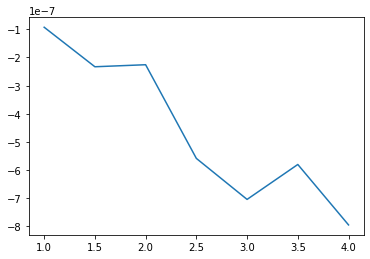

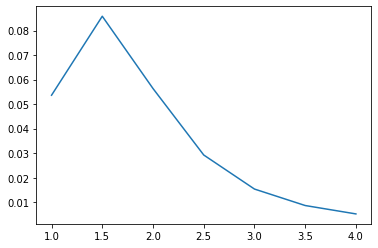

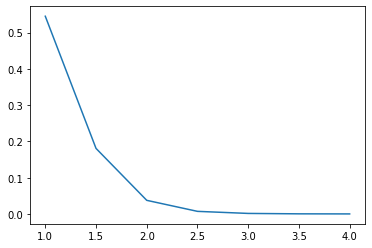

In [20]:
plt.figure()
plt.plot(g_list, sigma_x_expect)
plt.show()
plt.figure()
plt.plot(g_list, sigma_y_expect)
plt.show()
plt.figure()
plt.plot(g_list, sigma_z_expect)
plt.show()

In [21]:
initial_parameters = np.random.random(4 ** num_latt - 1)
gen_rho_dot(initial_parameters, 2, 1)

array([[-4.55464086e-01+0.00000000e+00j,  1.18926056e+00-3.56029641e-01j,
        -2.80732155e+00-4.59631673e-01j, -3.29257387e+00+1.19974698e+00j,
        -2.74248616e+00+1.02082216e+00j, -2.92794169e+00-2.46235168e+00j,
        -2.77138868e+00+2.44168089e-01j, -1.00942701e+00+8.54130817e-01j,
        -2.89945322e+00+1.74089490e+00j, -1.99661133e+00+5.81009747e-01j,
        -3.83194577e+00+1.49793950e+00j, -6.93729540e-01-8.36514823e-01j,
        -2.33766669e+00+7.64618421e-01j, -3.15216965e+00-5.42057381e-01j,
        -1.19101220e+00+8.92906721e-01j, -9.45883432e-01-6.36473437e-01j],
       [ 1.18926056e+00+3.56029641e-01j, -8.49744233e-01+0.00000000e+00j,
        -7.47941263e-02+2.18834002e+00j,  1.17980317e+00+2.50624003e-01j,
        -5.13319982e-01+1.92892690e+00j,  1.02302885e+00-4.92504337e-01j,
         8.40649136e-02+2.34032225e+00j, -1.42254091e+00+5.96350549e-01j,
        -3.48321418e+00+2.84891740e+00j, -1.81549808e+00-2.92243670e-01j,
        -1.88494203e+00-2.78896752e-0